# TRAINING - FEATURE ENGINEER

The objective of this notebook is to analyze the variables at a level that allows evaluating how they can be transformed or what relationship they have with other variables, to improve the ability of a model to explain the response variable.

## SET UP

In [3]:
!pip install findspark

import findspark
findspark.init()

## LIBRARIES

In [4]:
# Cargar Pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql.functions import *

spark = SparkSession.builder.appName("feature_engineer").master("local[*]").getOrCreate()

In [5]:
from pyspark.sql.functions import *
from pyspark.sql import Window
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression 
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.util import MLUtils

In [6]:
#https://stackoverflow.com/questions/55546467/how-to-plot-correlation-heatmap-when-using-pysparkdatabricks
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings('ignore')

## FUNCTIONS

In [30]:
def get_correlations(df,features):
    
    # Vectorize variables to define the features column
    feat_vector = VectorAssembler(inputCols=features, outputCol= "features")
    # Appply vectorization
    transData = feat_vector.transform(df)
    # Calculate matrix correlation
    matrix = Correlation.corr(transData, "features").collect()[0][0]
    # Transform to lists
    corrmatrix = matrix.toArray().tolist()
    # Transform to dataframe
    correlation_df = spark.createDataFrame(corrmatrix,features).toPandas()
    # Organize the dataframe
    index_df = pd.DataFrame(features,columns=["features"])
    matrix_correlations = pd.merge(index_df, correlation_df, left_index=True, right_index=True).set_index("features")
    # Round values
    matrix_correlations = matrix_correlations.round(2)
    
    return matrix_correlations

## LOAD DATA

In [9]:
# Path definition
path = "output/preprocessing/preprocessing_data"

In [10]:
# Read dataframe
df = spark.read.parquet(path, header= True, inferSchema=True)
df = df.withColumnRenamed("categoria","grupo")

In [11]:
# Cast binary variables
df = (df
         .withColumn("ind_mora_vigente",col("ind_mora_vigente").cast("integer"))
         .withColumn("cartera_castigada",col("cartera_castigada").cast("integer"))
         .withColumn("tenencia_tc",col("tenencia_tc").cast("integer"))
         .withColumn("tiene_consumo",col("tiene_consumo").cast("integer"))
         .withColumn("tiene_crediagil",col("tiene_crediagil").cast("integer"))
         .withColumn("tiene_ctas_activas",col("tiene_ctas_activas").cast("integer"))
         .withColumn("tiene_ctas_embargadas",col("tiene_ctas_embargadas").cast("integer"))
         .withColumn("tiene_cred_hipo_1",col("tiene_cred_hipo_1").cast("integer"))
         .withColumn("tiene_cred_hipo_2",col("tiene_cred_hipo_2").cast("integer"))
         .withColumn("pension_fopep",col("pension_fopep").cast("integer"))
        )

In [12]:
# Verify rows
df.count()

9670308

In [13]:
df.limit(5).toPandas().head()

,periodo,id_cli,fecha_nacimiento,edad,estado_civil,nivel_academico,tipo_vivienda,grupo,ind_mora_vigente,cartera_castigada,...,Pensionado,Indefinida,Desempleado,ANDINA,PACIFICO,EXTERIOR,CARIBE,ORINOQUIA,NI,AMAZONIA
0,202002,6243935,19960501,24.0,1,4,0,2.0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,201910,8685012,19801213,39.0,2,5,1,4.0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,202002,8685012,19801213,39.0,2,5,1,4.0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,202002,1003141,19910603,29.0,1,2,2,1.0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,202003,1003141,19910603,29.0,1,2,2,1.0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [14]:
# Clean input variables
input_values = df.columns
drop_values = ['grupo','periodo','id_cli','fecha_nacimiento','ult_actual','codigo_ciiu','profesion']
input_numericas = [x for x in input_values if x not in drop_values]

## MULTIVARIABLE ANALYSIS

In [12]:
# Vectorize variables to define the features column
feat_vector = VectorAssembler(inputCols=input_numericas, outputCol= "features")

In [13]:
# Appply vectorization
transData = feat_vector.transform(df)

In [14]:
matrix = Correlation.corr(transDat, "features").collect()[0][0]
corrmatrix = matrix.toArray().tolist()

In [15]:
correlation_df = spark.createDataFrame(corrmatrix,input_numericas).toPandas()

In [16]:
index_df = pd.DataFrame(input_numericas,columns=["variables"])

In [17]:
matrix_correlations = pd.merge(index_df, correlation_df, left_index=True, right_index=True).set_index("variables")

In [18]:
matrix_correlations = matrix_correlations.round(2)

In [22]:
correlation_target = matrix_correlations[["gasto_familiar"]].sort_values(by="gasto_familiar")

In [23]:
pd.set_option('display.max_rows', None)
display(correlation_target)

,gasto_familiar
variables,
cat_ingreso,-0.06
ingreso_nompen,-0.04
mediana_nom3,-0.04
ingreso_nomina,-0.03
Estudiante,-0.03
Empleado,-0.03
nivel_academico,-0.02
Pensionado,-0.02
tenencia_tc,-0.02


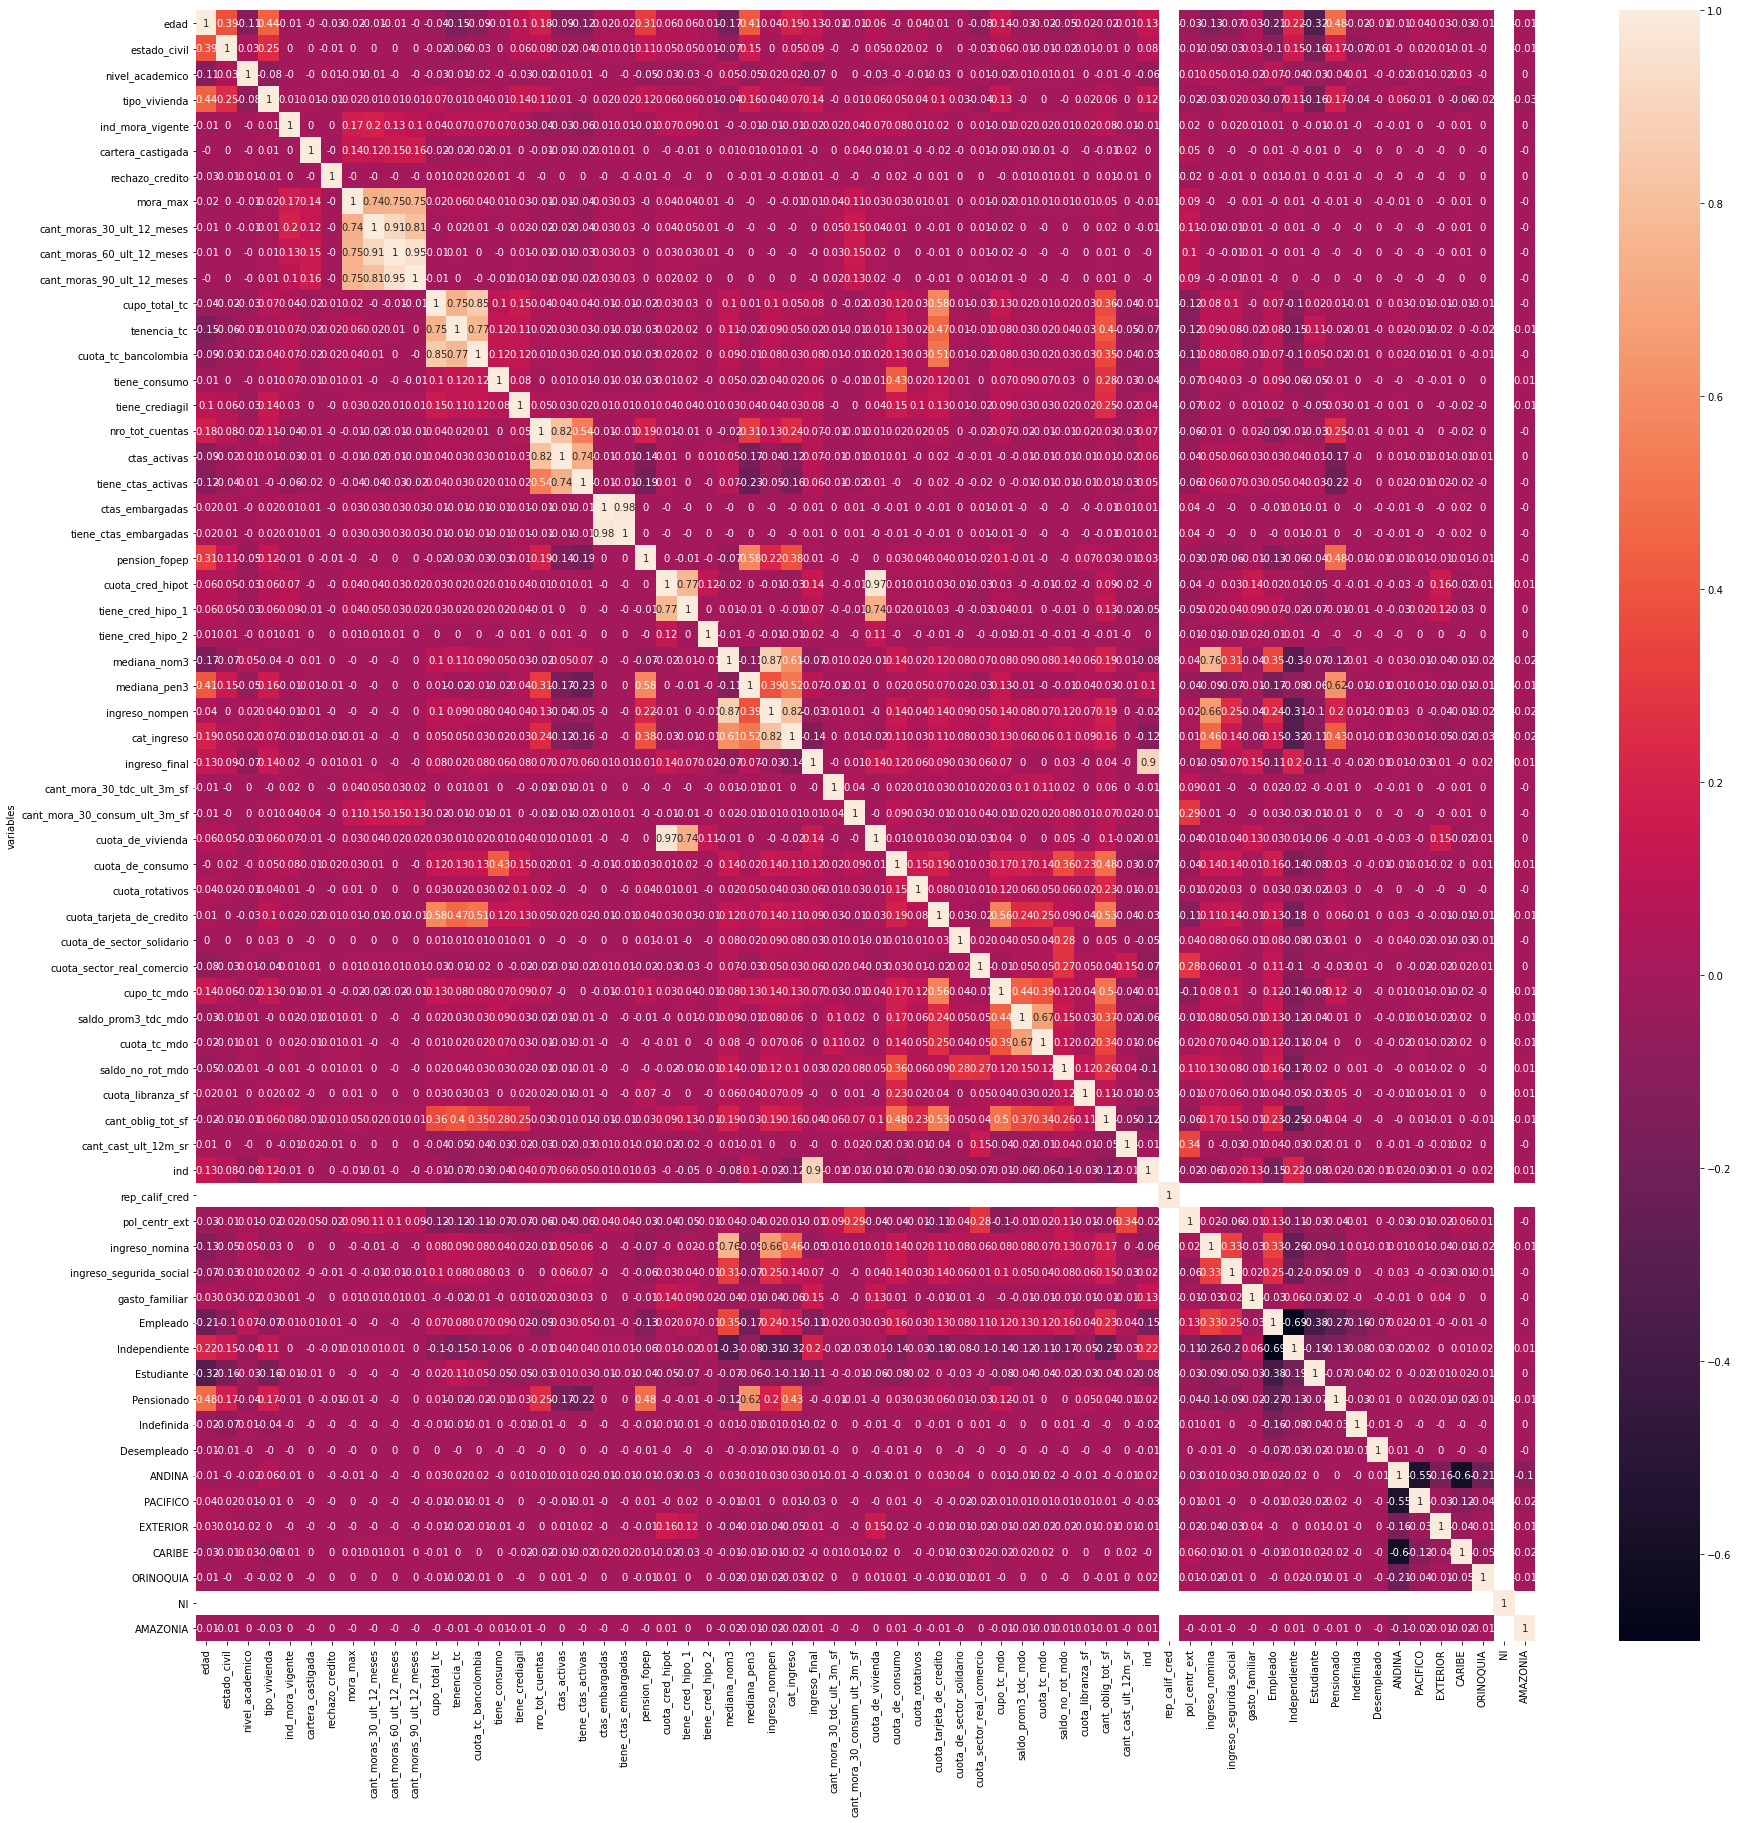

In [24]:
plt.figure(figsize=(30,30))
sns.heatmap(matrix_correlations, annot=True)

In [25]:
##matrix_correlations.to_csv("output/statistics/matrix_correlations.csv")

## ENGINEERING

1. Add expenses and income:

In [31]:
df_1 = df

In [32]:
# https://stackoverflow.com/questions/53297872/how-can-i-sum-multiple-columns-in-a-spark-dataframe-in-pyspark
df_1 = (df_1
        .withColumn("gastos"
                    , col('cuota_cred_hipot') 
                    + col('cuota_de_vivienda') 
                    + col('cuota_de_consumo')
                    + col('cuota_rotativos')
                    + col('cuota_tarjeta_de_credito')
                    + col('cuota_de_sector_solidario')
                    + col('cuota_sector_real_comercio')
                    + col('cuota_tc_mdo')
                    + col('cuota_libranza_sf')
                   )
        .withColumn("ingresos" 
                    ,col('ingreso_nompen')
                    + col('ingreso_final')
                    + col('ingreso_nomina')
                    + col('ingreso_segurida_social')
                   )
       )

In [33]:
# Clean input variables
input_values = df_1.columns
drop_values = ['grupo','periodo','id_cli','fecha_nacimiento','ult_actual','codigo_ciiu','profesion','rep_calif_cred','NI']
new_features = [x for x in input_values if x not in drop_values]

In [34]:
matrix_correlations = get_correlations(df_1,new_features)

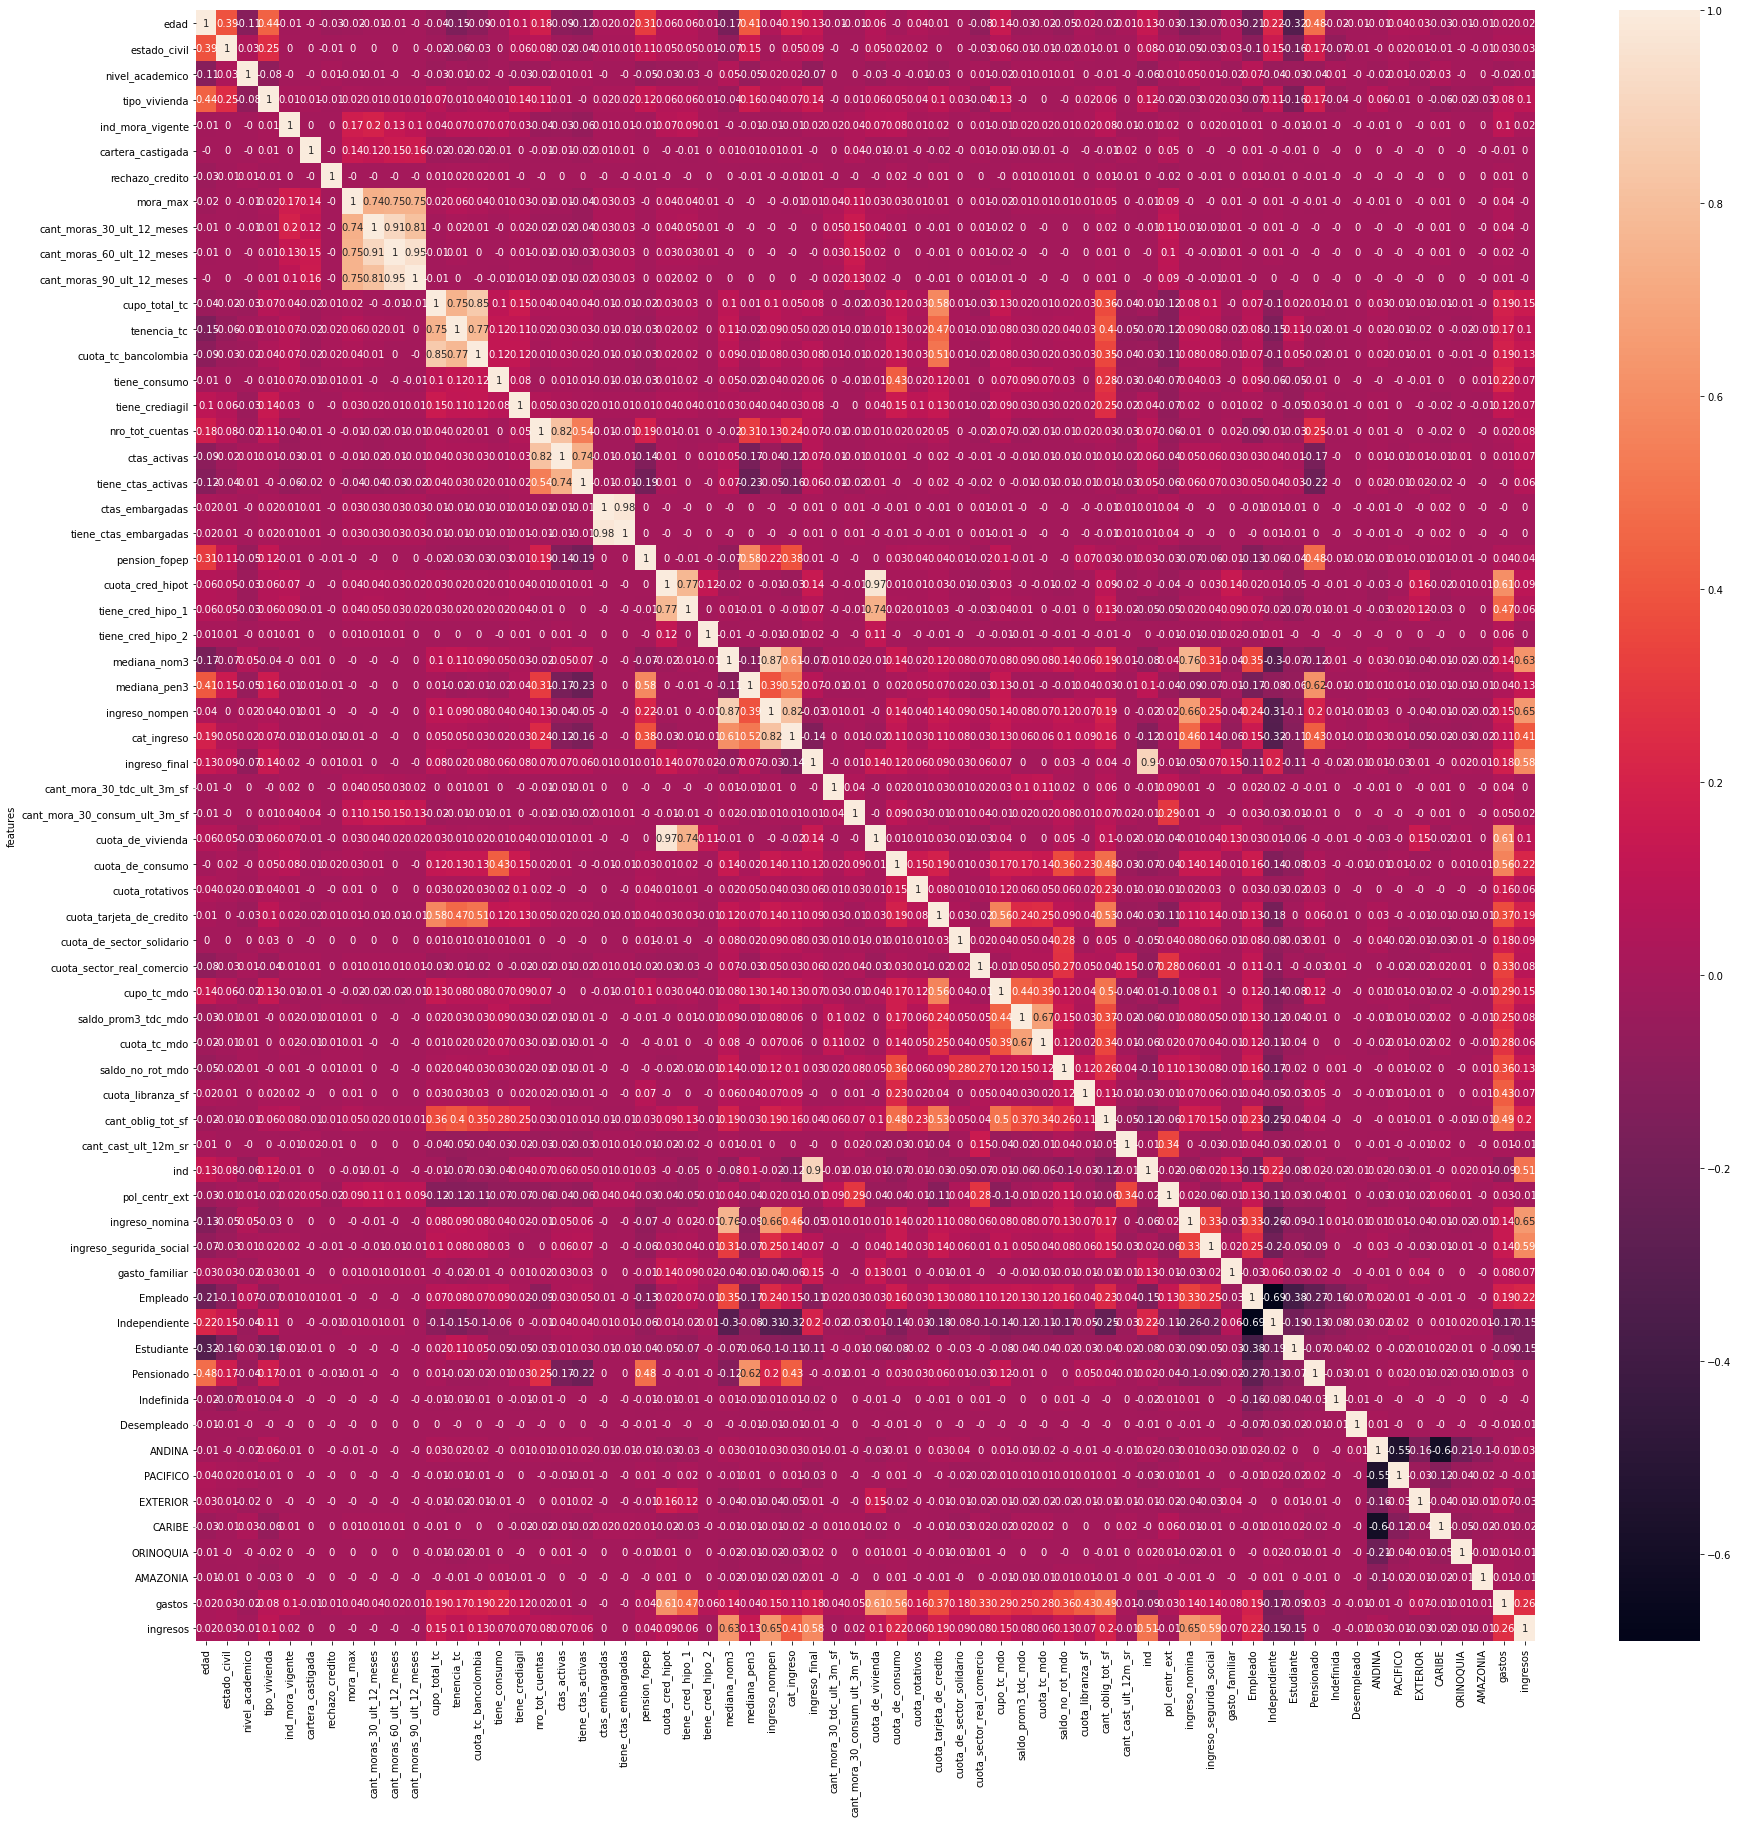

In [35]:
plt.figure(figsize=(30,30))
sns.heatmap(matrix_correlations, annot=True)

2. Eliminar variables que no generan ningun valor:

In [54]:
target = matrix_correlations[["gasto_familiar"]].round(2)
target["abs"] = target["gasto_familiar"].abs()
target = target[target["abs"]>=0.01]
target = target.sort_values(by="gasto_familiar",ascending=False).reset_index()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]),
 <a list of 47 Text major ticklabel objects>)

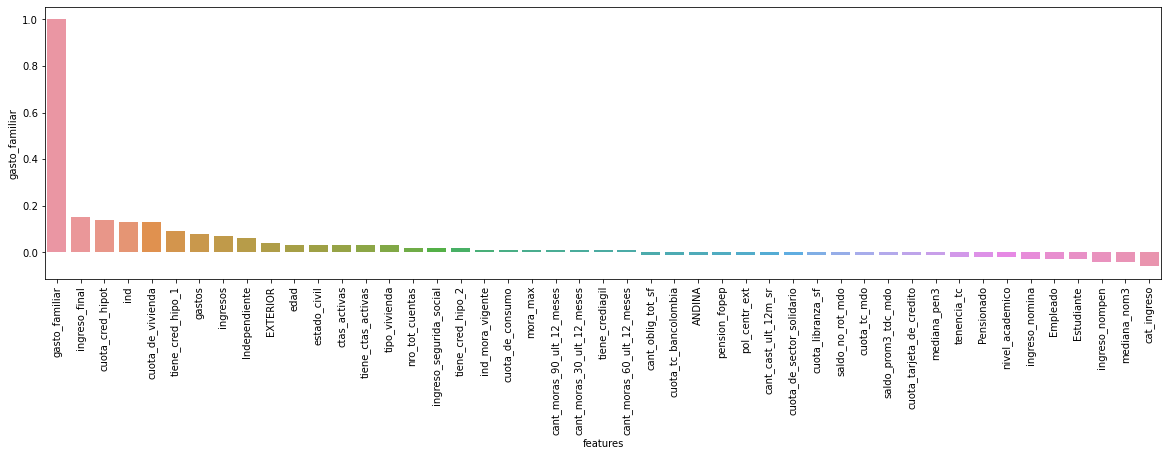

In [62]:
plt.figure(figsize=(20,5))
sns.barplot(x="features", y="gasto_familiar", data=target)
plt.xticks(rotation=90)

In [68]:
clean_features = target["features"].tolist()

In [69]:
matrix_correlations = get_correlations(df_2,clean_features)

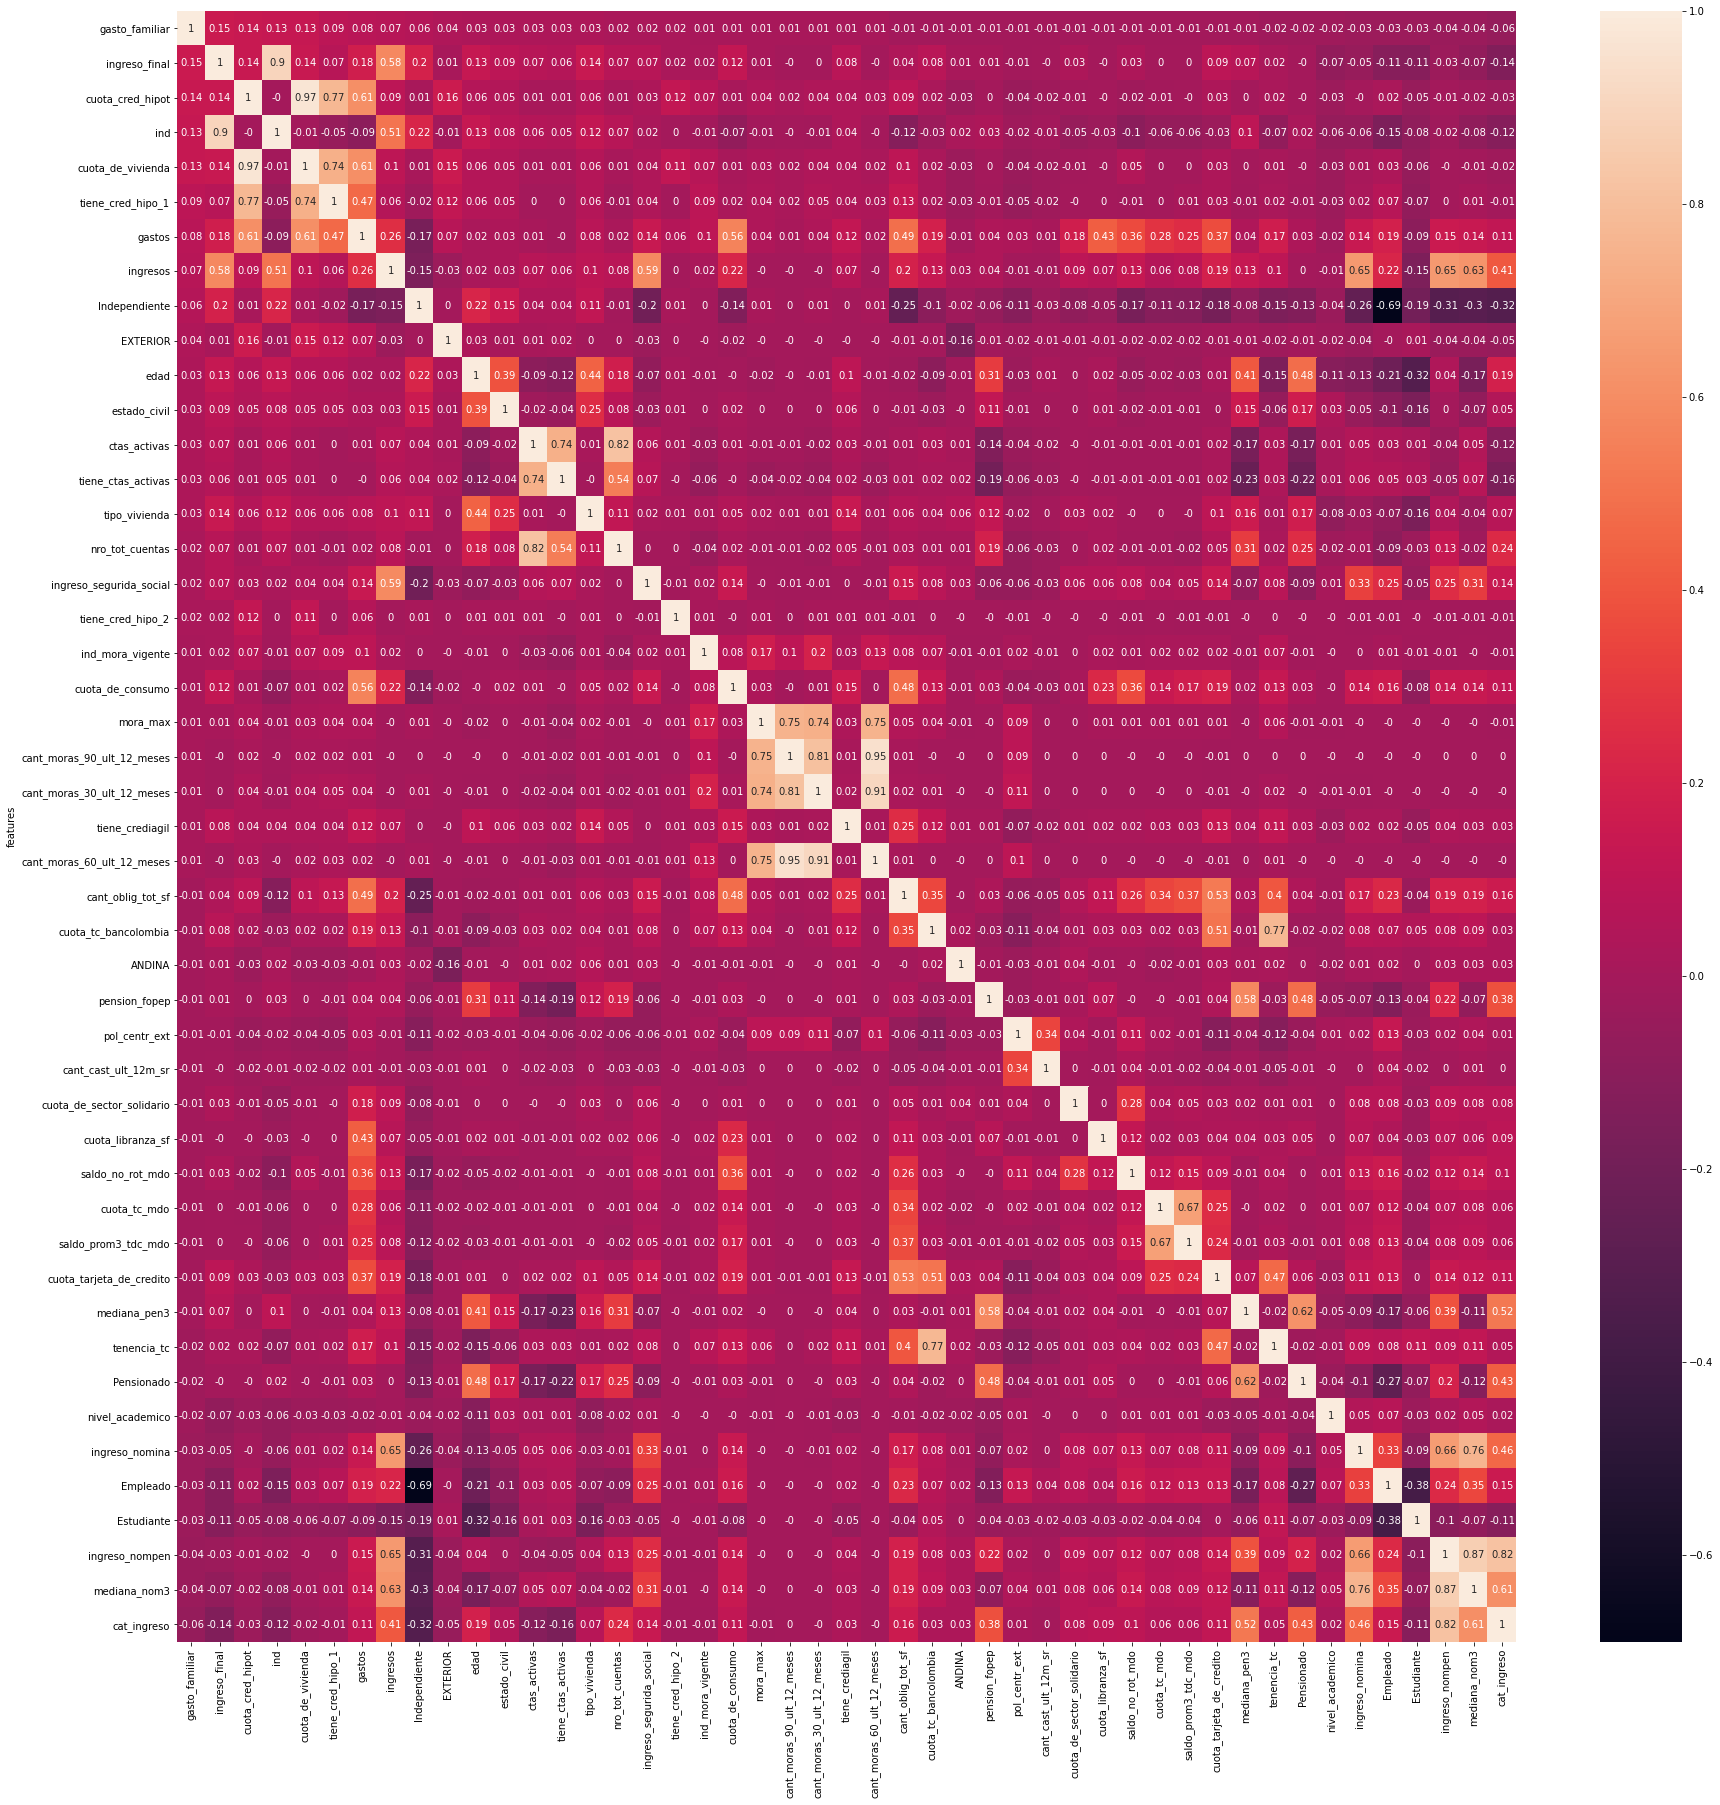

In [70]:
plt.figure(figsize=(30,30))
sns.heatmap(matrix_correlations, annot=True)

3. Select variables by collinearity:

In [107]:
correlation_target_dict = matrix_correlations[["gasto_familiar"]].sort_values(by="gasto_familiar").to_dict()['gasto_familiar']

In [155]:
data = []
for var in clean_features:
    analysis = []
    colineality = matrix_correlations[[var]]
    response = colineality[colineality[var].abs()>=0.7]
    response = response.sort_values(by=var,ascending=False).to_dict()[var]
    if len(response)>=2:
        # Transform to list to get keys values
        response_list = list(response)
        # var_eval
        var_eval = var
        analysis.append(var_eval)
        # val_eval
        val_eval = correlation_target_dict[var]
        analysis.append(val_eval)
        # var_col
        var_col = response_list[1]
        analysis.append(var_col)
        # val_col
        val_col = response[response_list[1]]
        analysis.append(val_col)
        # exp_col 
        exp_col = correlation_target_dict[var_col]
        analysis.append(exp_col)
        # Append row to main data
        data.append(analysis)

In [163]:
colinealidad_df = pd.DataFrame(data,columns=["var_eval","val_eval","var_col","val_col","exp_col"])
colinealidad_df["drop"] = np.where(colinealidad_df["val_eval"].abs() > colinealidad_df["exp_col"].abs(),colinealidad_df["var_col"],colinealidad_df["var_eval"] )

In [177]:
pd.set_option('display.max_rows', None)
colinealidad_df

,var_eval,val_eval,var_col,val_col,exp_col,drop
0,ingreso_final,0.15,ind,0.90,0.13,ind
1,cuota_cred_hipot,0.14,cuota_de_vivienda,0.97,0.13,cuota_de_vivienda
2,ind,0.13,ingreso_final,0.90,0.15,ind
3,cuota_de_vivienda,0.13,cuota_cred_hipot,0.97,0.14,cuota_de_vivienda
4,tiene_cred_hipo_1,0.09,cuota_cred_hipot,0.77,0.14,tiene_cred_hipo_1
5,ctas_activas,0.03,nro_tot_cuentas,0.82,0.02,nro_tot_cuentas
6,tiene_ctas_activas,0.03,ctas_activas,0.74,0.03,tiene_ctas_activas
7,nro_tot_cuentas,0.02,ctas_activas,0.82,0.03,nro_tot_cuentas
8,mora_max,0.01,cant_moras_90_ult_12_meses,0.75,0.01,mora_max
9,cant_moras_90_ult_12_meses,0.01,cant_moras_60_ult_12_meses,0.95,0.01,cant_moras_90_ult_12_meses


In [170]:
drop_colinealidad = colinealidad_df[["drop"]]
drop_colinealidad = drop_colinealidad["drop"].unique().tolist() 
drop_colinealidad

['ind',
 'cuota_de_vivienda',
 'tiene_cred_hipo_1',
 'nro_tot_cuentas',
 'tiene_ctas_activas',
 'mora_max',
 'cant_moras_90_ult_12_meses',
 'cant_moras_30_ult_12_meses',
 'cant_moras_60_ult_12_meses',
 'cuota_tc_bancolombia',
 'ingreso_nomina',
 'ingreso_nompen',
 'mediana_nom3']

In [173]:
drop_colinealidad = [
    'ind',
     'cuota_de_vivienda',
     'tiene_cred_hipo_1',
     'nro_tot_cuentas',
     'tiene_ctas_activas',
     'mora_max',
     'cant_moras_60_ult_12_meses',
     'cuota_tc_bancolombia',
     'ingreso_nomina',
     'ingreso_nompen',
     'mediana_nom3'
]

## CONCLUSION

In [174]:
# Clean input variables
input_values = clean_features
drop_values = drop_colinealidad
new_features = [x for x in input_values if x not in drop_values]

In [175]:
len(new_features)

36

In [176]:
new_features

['gasto_familiar',
 'ingreso_final',
 'cuota_cred_hipot',
 'gastos',
 'ingresos',
 'Independiente',
 'EXTERIOR',
 'edad',
 'estado_civil',
 'ctas_activas',
 'tipo_vivienda',
 'ingreso_segurida_social',
 'tiene_cred_hipo_2',
 'ind_mora_vigente',
 'cuota_de_consumo',
 'cant_moras_90_ult_12_meses',
 'cant_moras_30_ult_12_meses',
 'tiene_crediagil',
 'cant_oblig_tot_sf',
 'ANDINA',
 'pension_fopep',
 'pol_centr_ext',
 'cant_cast_ult_12m_sr',
 'cuota_de_sector_solidario',
 'cuota_libranza_sf',
 'saldo_no_rot_mdo',
 'cuota_tc_mdo',
 'saldo_prom3_tdc_mdo',
 'cuota_tarjeta_de_credito',
 'mediana_pen3',
 'tenencia_tc',
 'Pensionado',
 'nivel_academico',
 'Empleado',
 'Estudiante',
 'cat_ingreso']

In [178]:
matrix_correlations = get_correlations(df_1,new_features)

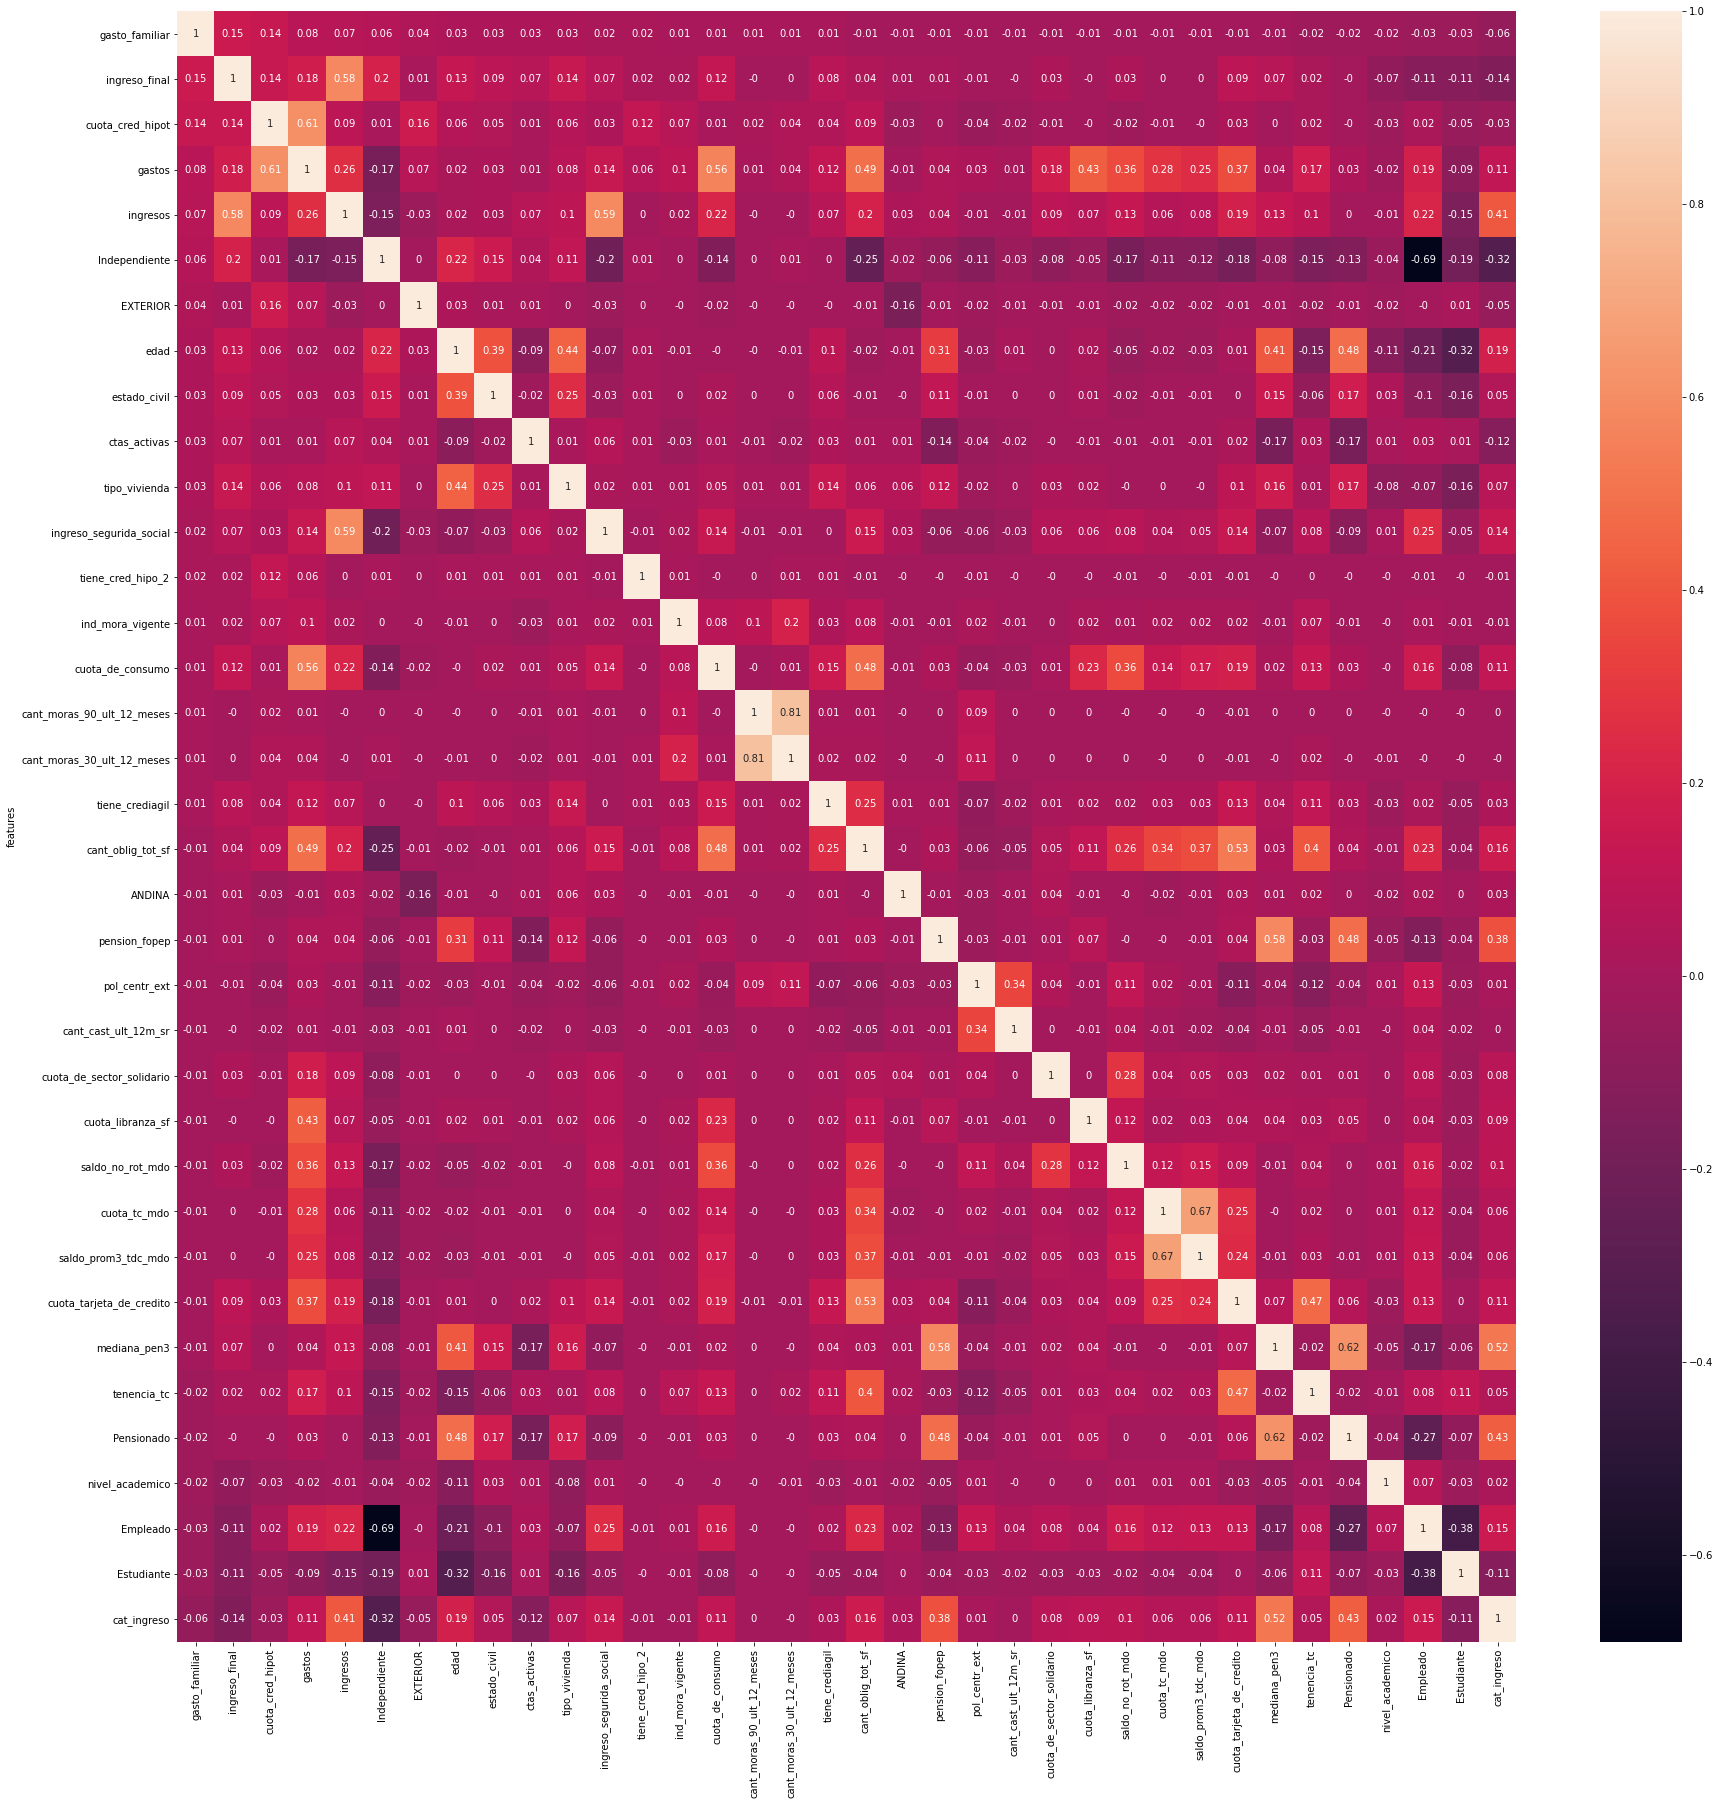

In [179]:
plt.figure(figsize=(30,30))
sns.heatmap(matrix_correlations, annot=True)